# Nail Disease Classifier V1

# VGG16 Model

In [ ]:
!pip install torchmetrics

In [ ]:
from google.colab import drive
from pathlib import Path
drive.mount('/content/drive')

in_colab = True

if in_colab:
    DATA_DIR = Path("/content/drive/MyDrive/Nail disease detection/data/")
else:
    DATA_DIR = Path("data/")

Mounted at /content/drive


In [ ]:
import torch, torchvision, torchmetrics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

## Data Preparation

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
from torchvision import datasets, transforms as T


TRAIN_DIR = DATA_DIR / "train"
TEST_DIR = DATA_DIR / "test"
VALID_DIR = DATA_DIR / "valid"

RANDOM_SEED = 0

In [ ]:
# Plotting random images
import random
from PIL import Image

def plot_images(data_dir: Path,
                transforms: T=None,
                random_seed: int=None):
    random.seed(random_seed)

    image_path_list = list(data_dir.glob("*/*/*.jpg"))
    fig = plt.figure(figsize=(10,7))
    rows, cols = 3, 3

    for i in range(1, rows * cols + 1):
        random_img_path = random.choice(image_path_list)
        img_class = random_img_path.parent.stem
        fig.add_subplot(rows, cols, i)
        random_img = Image.open(random_img_path)

        if transforms:
            transformed_img = transforms(random_img)
            plt.imshow(transformed_img.permute(1, 2, 0))
        else:
            plt.imshow(random_img)
        plt.title(f"{img_class} ({random_img.height}, {random_img.width})")
        plt.axis(False)


### Raw images

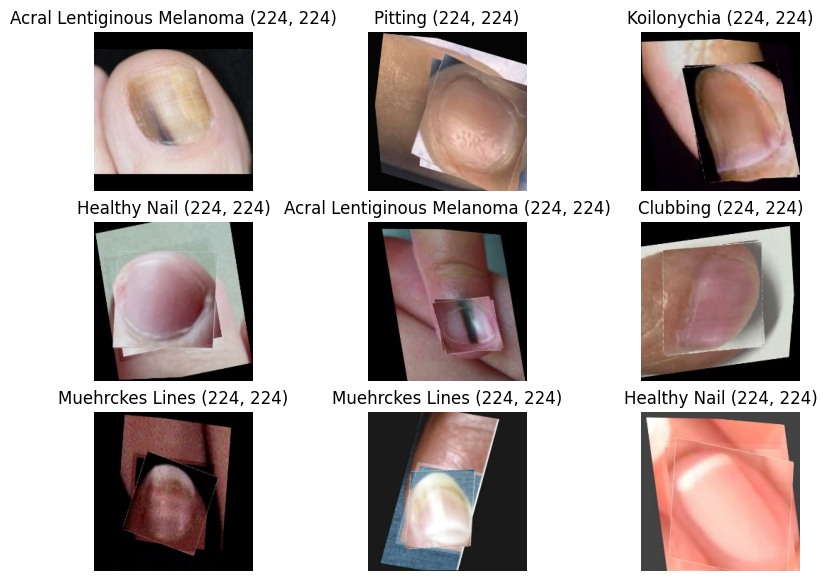

In [ ]:
plot_images(data_dir=DATA_DIR, random_seed=RANDOM_SEED)

### Transforms

In [ ]:
transform = T.Compose([
    T.Resize(size=(224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

### Transformed Images

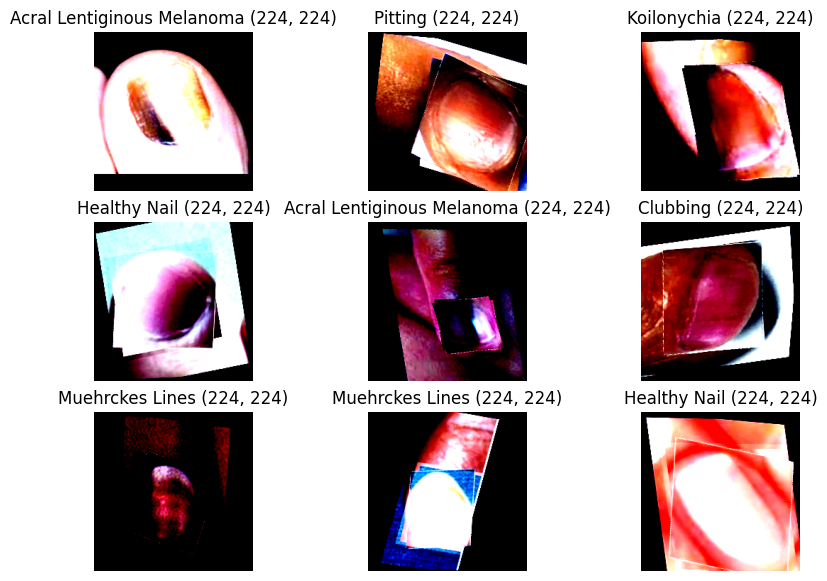

In [ ]:
plot_images(data_dir=DATA_DIR, transforms=transform, random_seed=RANDOM_SEED)

In [ ]:
train_data = datasets.ImageFolder(root=TRAIN_DIR,
                                  transform=transform,
                                  target_transform=None)

test_data = datasets.ImageFolder(root=TEST_DIR,
                                  transform=transform,
                                  target_transform=None)

valid_data = datasets.ImageFolder(root=VALID_DIR,
                                  transform=transform,
                                  target_transform=None)

class_names = train_data.classes

print(f"Train data length: {len(train_data)}")
print(f"Test data length: {len(test_data)}")
print(f"Valid data length: {len(valid_data)}")
print(f"Number of Classes: {len(class_names)}")
print(f"Class Names: \n{class_names}")

Train data length: 6360
Test data length: 307
Valid data length: 591
Number of Classes: 10
Class Names: 
['Acral Lentiginous Melanoma', 'Beaus Line', 'Blue Finger', 'Clubbing', 'Healthy Nail', 'Koilonychia', 'Muehrckes Lines', 'Onychogryphosis', 'Pitting', 'Terry-s Nail']


### Data Loader

In [ ]:
from torch.utils.data import DataLoader

torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=NUM_WORKERS)

test_dataloader = DataLoader(dataset=test_data,
                              batch_size=BATCH_SIZE,
                              shuffle=False,
                              num_workers=NUM_WORKERS)

valid_dataloader = DataLoader(dataset=valid_data,
                              batch_size=BATCH_SIZE,
                              shuffle=False,
                              num_workers=NUM_WORKERS)

print(f"Train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")
print(f"Valid dataloader: {len(valid_dataloader)} batches of {BATCH_SIZE}")

Train dataloader: 199 batches of 32
Test dataloader: 10 batches of 32
Valid dataloader: 19 batches of 32


In [ ]:
img, label = next(iter(train_dataloader))

img.shape, label.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

## Model Building

In [ ]:
import torchvision.models as models
from torchmetrics import Accuracy
from torch import nn

vgg16 = models.vgg16(weights=models.VGG16_Weights.DEFAULT)

# Change VGG16 to output 10 classes
vgg16.classifier[6] = nn.Linear(in_features=4096, out_features=len(class_names))
vgg16 = vgg16.to(device)

criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(params=vgg16.parameters(),
                            lr=0.01)
accuracy_fn = Accuracy(task='multiclass', num_classes=len(class_names)).to(device)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 148MB/s]


In [ ]:
next(vgg16.parameters()).device

device(type='cuda', index=0)

In [ ]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               criterion: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    """Performs training with model trying to learn on `data_loader`"""

    train_loss, train_acc = 0, 0

    model.train()
    for batch, (X_train, y_train) in enumerate(data_loader):

        # Put data on target device
        X_train, y_train = X_train.to(device), y_train.to(device)

        # Forward pass (outputs the raw logits from the model)
        y_pred = model(X_train)

        loss = criterion(y_pred, y_train)
        train_loss += loss
        train_acc += accuracy_fn(y_train, y_pred.argmax(dim=1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 10 == 0:
            print(f"Looked at {batch * len(X_train)} / {len(train_dataloader.dataset)} samples")

    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    return train_loss, train_acc

In [ ]:
def valid_step(model: torch.nn.Module,
                    data_loader: torch.utils.data.DataLoader,
                    criterion: torch.nn.Module,
                    accuracy_fn,
                    device: torch.device):
    """Performs validation with model trying to learn on `data_loader`"""

    valid_loss, valid_acc = 0, 0

    model.eval()
    with torch.inference_mode():
        for X_valid, y_valid in data_loader:
            X_valid, y_valid = X_valid.to(device), y_valid.to(device)

            valid_pred = model(X_valid)

            valid_loss += criterion(valid_pred, y_valid)
            valid_acc += accuracy_fn(y_valid, valid_pred.argmax(dim=1))

        valid_loss /= len(data_loader)
        valid_acc /= len(data_loader)
    return valid_loss, valid_acc

In [ ]:
from timeit import default_timer as timer
from tqdm.auto import tqdm

def train_model(epochs: int,
          model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          valid_dataloader: torch.utils.data.DataLoader,
          criterion: torch.nn.Module,
          optimizer: torch.optim.Optimizer,
          accuracy_fn,
          device: torch.device=device):

    # Create  empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "valid_loss": [],
               "valid_acc": []}

    start_time = timer()

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model, train_dataloader, criterion, optimizer, accuracy_fn, device)
        test_loss, test_acc = valid_step(model, valid_dataloader, criterion, accuracy_fn, device)

        print(f"Epoch: {epoch} | Train loss: {train_loss:.4f}, Train accuracy : {train_acc:.4f} | Valid loss: {test_loss:.4f}, Valid accuracy: {test_acc:.4f}")

        # Update results dictionary
        results["train_loss"].append(train_loss.item())
        results["train_acc"].append(train_acc.item())
        results["valid_loss"].append(test_loss.item())
        results["valid_acc"].append(test_acc.item())

    end_time = timer()
    training_time = end_time - start_time

    print(f"Total time on {device}: {training_time:.3f}")

    return results

## Training the Model

In [ ]:
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

EPOCHS = 5

vgg16_results = train_model(epochs=EPOCHS,
                            model=vgg16,
                            train_dataloader=train_dataloader,
                            valid_dataloader=valid_dataloader,
                            criterion=criterion,
                            optimizer=optimizer,
                            accuracy_fn=accuracy_fn,
                            device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Looked at 0 / 6360 samples
Looked at 320 / 6360 samples
Looked at 640 / 6360 samples
Looked at 960 / 6360 samples
Looked at 1280 / 6360 samples
Looked at 1600 / 6360 samples
Looked at 1920 / 6360 samples
Looked at 2240 / 6360 samples
Looked at 2560 / 6360 samples
Looked at 2880 / 6360 samples
Looked at 3200 / 6360 samples
Looked at 3520 / 6360 samples
Looked at 3840 / 6360 samples
Looked at 4160 / 6360 samples
Looked at 4480 / 6360 samples
Looked at 4800 / 6360 samples
Looked at 5120 / 6360 samples
Looked at 5440 / 6360 samples
Looked at 5760 / 6360 samples
Looked at 6080 / 6360 samples
Epoch: 0 | Train loss: 0.0137, Train accuracy : 0.9973 | Valid loss: 1.3779, Valid accuracy: 0.7872
Looked at 0 / 6360 samples
Looked at 320 / 6360 samples
Looked at 640 / 6360 samples
Looked at 960 / 6360 samples
Looked at 1280 / 6360 samples
Looked at 1600 / 6360 samples
Looked at 1920 / 6360 samples
Looked at 2240 / 6360 samples
Looked at 2560 / 6360 samples
Looked at 2880 / 6360 samples
Looked at 32

In [ ]:
import pandas as pd
vgg16_results = pd.DataFrame(vgg16_results)

vgg16_results

,train_loss,train_acc,valid_loss,valid_acc
0,0.013663,0.997330,1.377864,0.787171
1,0.056503,0.988379,0.953633,0.751206
2,0.021042,0.993719,1.267741,0.772368
3,0.006256,0.998273,1.505978,0.777303
4,0.001572,1.000000,1.548927,0.778947


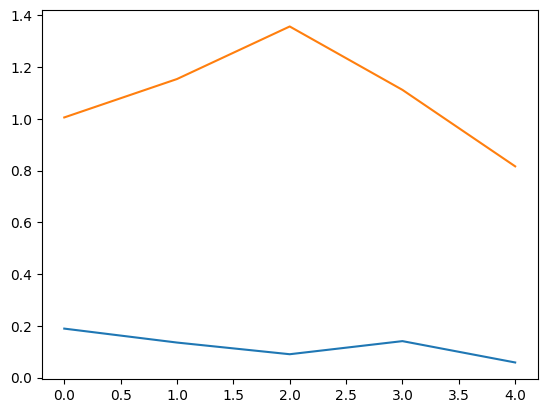

In [ ]:
plt.plot(vgg16_results['train_loss'])
plt.plot(vgg16_results['valid_loss'])

In [ ]:
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)
FILE_NAME = "vgg_16_epoch_15.pth"

MODEL_SAVE_PATH = MODEL_PATH / FILE_NAME

print(f"Saving to {MODEL_SAVE_PATH}")
torch.save(obj=vgg16.state_dict(), f=MODEL_SAVE_PATH)

Saving to models/vgg_16_epoch_15.pth


## Making predictions

In [ ]:
import random

test_samples = []
test_labels = []

for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

In [ ]:
# Make predictions
pred_probs = []

vgg16.eval()
with torch.inference_mode():
    for sample in test_samples:
        sample = torch.unsqueeze(sample, dim=0).to(device) # Add batch dimension
        logit = vgg16(sample)
        pred = torch.softmax(logit.squeeze(), dim=0)
        pred_probs.append(pred.cpu())

pred_probs = torch.stack(pred_probs)
pred_classes = torch.argmax(pred_probs, dim=1)

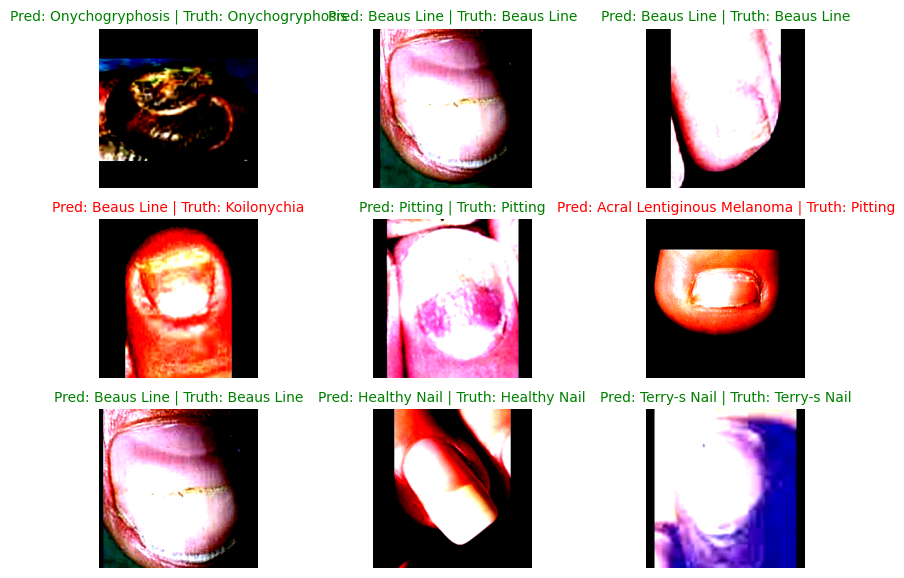

In [ ]:
plt.figure(figsize=(10, 7))

rows, cols = 3, 3

for i, sample in enumerate(test_samples):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(sample.squeeze(dim=0).permute(1, 2, 0), cmap="gray")

    pred_label = class_names[pred_classes[i]]
    truth_label = class_names[test_labels[i]]
    title_text = f"Pred: {pred_label} | Truth: {truth_label}"

    if pred_label == truth_label:
        plt.title(title_text, fontsize=10, c="g")  # green text if prediction is correct
    else:
        plt.title(title_text, fontsize=10, c="r")  # red text if prediction is incorrect

    plt.axis(False)

## Confusion Matrix

In [ ]:
y_preds = []

vgg16.eval()
with torch.inference_mode():
    for X, y, in tqdm(test_dataloader, desc="Making predictions"):
        X, y = X.to(device), y.to(device)
        y_logits = vgg16(X)
        y_pred = torch.softmax(y_logits.squeeze(), dim=1).argmax(dim=1)
        y_preds.append(y_pred.cpu())

y_preds = torch.cat(y_preds)
y_true = torch.tensor(test_data.targets)
y_preds

Making predictions:   0%|          | 0/10 [00:00<?, ?it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 3, 8, 1, 1, 1, 2, 0, 0, 2, 3, 3,
        1, 2, 3, 1, 2, 0, 2, 2, 9, 3, 2, 2, 0, 2, 2, 3, 3, 6, 1, 3, 9, 1, 3, 1,
        3, 3, 9, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 4, 7, 3,
        3, 3, 3, 3, 3, 4, 4, 4, 9, 4, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 4, 4,
        4, 4, 2, 4, 4, 0, 4, 4, 3, 0, 4, 5, 5, 7, 3, 3, 1, 7, 1, 1, 8, 3, 7, 1,
        1, 1, 1, 6, 5, 6, 0, 5, 5, 5, 1, 5, 8, 1, 8, 6, 6, 1, 1, 6, 5, 6, 6, 6,
        1, 6, 6, 6, 6, 6, 1, 7, 7, 7, 7, 1, 7, 7, 0, 7, 7, 7, 7, 7, 7, 7, 7, 7,
        7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 7, 7, 7, 7, 6, 7, 7, 8, 8, 8, 8, 8, 8, 8,
        8, 8, 8, 8, 8, 0, 8, 8, 8, 8, 0, 6, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8,
        8, 2, 0, 9, 9, 9, 9, 0, 9, 9, 9, 9, 9, 9, 9, 9, 9, 4, 9, 4, 9, 9, 9, 9,
        1, 9, 4, 9, 9, 9, 9, 9, 4, 9, 9,

In [ ]:
len(y_preds), len(y_true)

(307, 307)

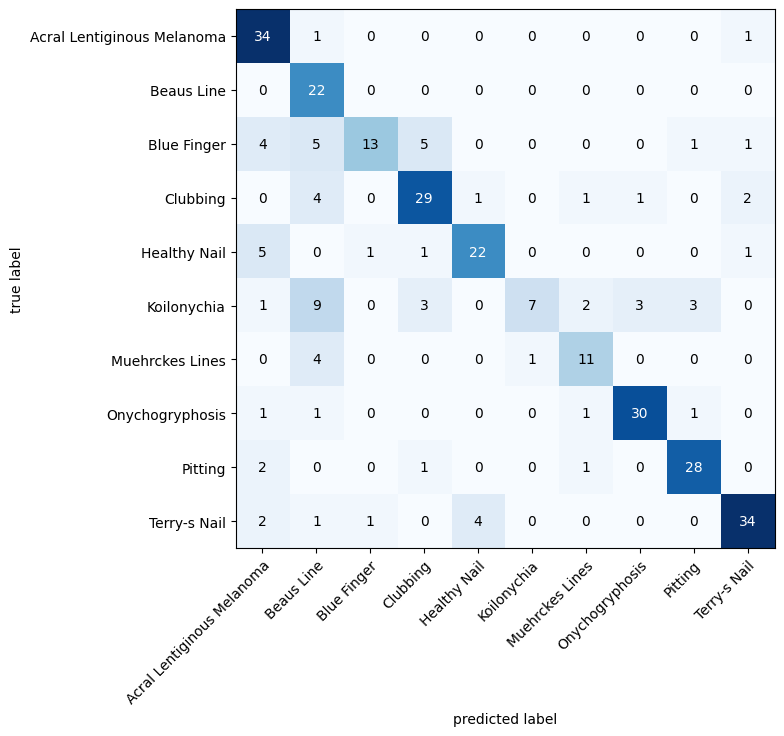

In [ ]:
from mlxtend.plotting import plot_confusion_matrix
from torchmetrics import ConfusionMatrix

conf_mat = ConfusionMatrix(task="multiclass", num_classes=len(class_names))
conf_mat_tensor = conf_mat(y_preds, y_true)

fig, ax = plot_confusion_matrix(conf_mat=conf_mat_tensor.numpy(), class_names=class_names, figsize=(10,7))

In [ ]:
from sklearn.metrics import classification_report
report = classification_report(y_preds, y_true, target_names=class_names)
print(report)

                            precision    recall  f1-score   support

Acral Lentiginous Melanoma       0.94      0.69      0.80        49
                Beaus Line       1.00      0.47      0.64        47
               Blue Finger       0.45      0.87      0.59        15
                  Clubbing       0.76      0.74      0.75        39
              Healthy Nail       0.73      0.81      0.77        27
               Koilonychia       0.25      0.88      0.39         8
           Muehrckes Lines       0.69      0.69      0.69        16
           Onychogryphosis       0.88      0.88      0.88        34
                   Pitting       0.88      0.85      0.86        33
              Terry-s Nail       0.81      0.87      0.84        39

                  accuracy                           0.75       307
                 macro avg       0.74      0.78      0.72       307
              weighted avg       0.82      0.75      0.76       307

